# Transfer Learning - Project

## Student Identity

In [1]:
# @title #### Student Identity
student_id = "READ59HZ" # @param {type:"string"}
name = "Salwa Ziada Salsabiila" # @param {type:"string"}
drive_link = "https://drive.google.com/drive/folders/1cXRqIGaIRZGUVG-7M3TAhLLwDYZRLCiP?usp=sharing"  # @param {type:"string"}

## Import package

In [2]:
!pip install rggrader
from rggrader import submit, submit_image

## Task 1: Transfer Learning for Emotion Recognition

In this project, you will use a [Vision Transformer (ViT)](https://huggingface.co/google/vit-base-patch16-224-in21k) model pre-trained on ImageNet-21k and fine-tune it on the [FastJobs/Visual_Emotional_Analysis](https://huggingface.co/datasets/FastJobs/Visual_Emotional_Analysis) dataset for emotion recognition, with the final step being the publication of your trained model to the Hugging Face Model Hub.

### Step 1: Environment Setup

In this section, we start by installing the necessary packages and logging into Hugging Face's platform:
- `transformers`
- `datasets`
- `evaluate`
- `huggingface_hub`

In [3]:
# Install necessary packages

# Put your code here:
!pip install transformers datasets evaluate
!pip install accelerate -U

import datasets
# ---- End of your code ----

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 6.9 MB/s eta 0:00:00


After installing, use the Hugging Face's notebook login function to log into Hugging Face's platform. Execute the following commands in your cell:

In [4]:
from huggingface_hub import notebook_login

notebook_login()


### Step 2: Load the Dataset

Load the "FastJobs/Visual_Emotional_Analysis" dataset and split it into training and test sets with a test size of 0.2.

> **Note**: please assign to variable `emotion`

In [5]:
from datasets import load_dataset
emotion = load_dataset("FastJobs/Visual_Emotional_Analysis", split="train[:250]")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

emotion = emotion.train_test_split(test_size=0.2)

**Label Mapping**

> **Note**: no need to change the code below! Just run it to map labels from the dataset.

In [7]:
labels = emotion["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

### Step 3: Explore and Visualize the Dataset

In this step, you are required to visualize the first instance in the training dataset.

> **Note**: no need to change the code below! Just run it to visualize the dataset based on index.

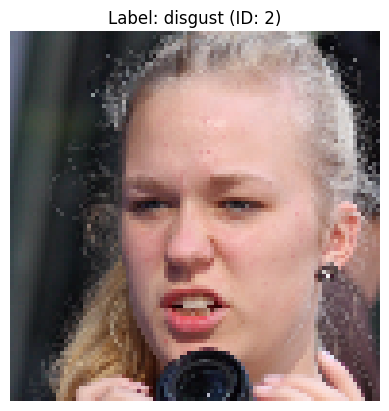

In [8]:
import matplotlib.pyplot as plt

# Define the function to convert label index to label name
id2label_view = {str(i): label for i, label in enumerate(labels)}

# Use first training example
image = emotion['train'][0]['image'] # Explore image by index
label_id = str(emotion['train'][0]['label'])
label_name = id2label_view[label_id]

# Display the image and its corresponding label
plt.imshow(image)
plt.title(f'Label: {label_name} (ID: {label_id})')
plt.axis('off')
plt.show()

### Step 4: Preprocess the Data

You need to define the transformation function for image preprocessing and apply it to the dataset.

In [9]:
label2id

{'anger': '0',
 'contempt': '1',
 'disgust': '2',
 'fear': '3',
 'happy': '4',
 'neutral': '5',
 'sad': '6',
 'surprise': '7'}

In [10]:
id2label

{'0': 'anger',
 '1': 'contempt',
 '2': 'disgust',
 '3': 'fear',
 '4': 'happy',
 '5': 'neutral',
 '6': 'sad',
 '7': 'surprise'}

In [11]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [12]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [13]:
emotion["train"][100]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96>,
 'label': 0}

In [14]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [15]:
emotion = emotion.with_transform(transforms)

In [16]:
emotion

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 50
    })
})

In [17]:
emotion["train"][0]

{'label': 2,
 'pixel_values': tensor([[[ 0.1373,  0.1373,  0.1451,  ...,  0.6078,  0.5922,  0.5922],
          [ 0.1373,  0.1373,  0.1451,  ...,  0.6078,  0.5922,  0.5922],
          [ 0.1451,  0.1451,  0.1529,  ...,  0.6235,  0.6078,  0.6078],
          ...,
          [-0.4980, -0.4980, -0.4980,  ..., -0.4039, -0.4118, -0.4118],
          [-0.4980, -0.4980, -0.4980,  ..., -0.4275, -0.4275, -0.4275],
          [-0.4980, -0.4980, -0.4980,  ..., -0.4275, -0.4275, -0.4275]],
 
         [[-0.1843, -0.1843, -0.1765,  ...,  0.5686,  0.5529,  0.5529],
          [-0.1843, -0.1843, -0.1765,  ...,  0.5686,  0.5529,  0.5529],
          [-0.1765, -0.1765, -0.1686,  ...,  0.5765,  0.5686,  0.5686],
          ...,
          [-0.7255, -0.7255, -0.7176,  ..., -0.5608, -0.5608, -0.5608],
          [-0.7176, -0.7176, -0.7176,  ..., -0.5765, -0.5765, -0.5765],
          [-0.7176, -0.7176, -0.7176,  ..., -0.5765, -0.5765, -0.5765]],
 
         [[-0.3098, -0.3098, -0.3020,  ...,  0.5529,  0.5373,  0.5373],

In [18]:
labels = emotion["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [19]:
# Preprocess
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [20]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [21]:
emotion["train"][100]

{'label': 0,
 'pixel_values': tensor([[[-0.4118, -0.4118, -0.4118,  ...,  0.6941,  0.7176,  0.7176],
          [-0.4118, -0.4118, -0.4118,  ...,  0.6941,  0.7176,  0.7176],
          [-0.4118, -0.4118, -0.4118,  ...,  0.6941,  0.7176,  0.7176],
          ...,
          [-0.5216, -0.5216, -0.5216,  ...,  0.5373,  0.5529,  0.5529],
          [-0.5216, -0.5216, -0.5216,  ...,  0.5373,  0.5529,  0.5529],
          [-0.5216, -0.5216, -0.5216,  ...,  0.5373,  0.5529,  0.5529]],
 
         [[-0.3333, -0.3333, -0.3333,  ...,  0.3569,  0.3804,  0.3804],
          [-0.3333, -0.3333, -0.3333,  ...,  0.3569,  0.3804,  0.3804],
          [-0.3333, -0.3333, -0.3333,  ...,  0.3569,  0.3804,  0.3804],
          ...,
          [-0.4745, -0.4745, -0.4745,  ...,  0.2392,  0.2549,  0.2549],
          [-0.4745, -0.4745, -0.4745,  ...,  0.2392,  0.2549,  0.2549],
          [-0.4745, -0.4745, -0.4745,  ...,  0.2392,  0.2549,  0.2549]],
 
         [[-0.6000, -0.6000, -0.6000,  ...,  0.3020,  0.3255,  0.3255],

In [22]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [23]:
emotion = emotion.with_transform(transforms)

In [24]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [25]:
import evaluate

accuracy = evaluate.load("accuracy")

In [26]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

### Step 5: Model Setup

In this step, define the model architecture with the pre-trained ViT model and load it.

In [27]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)
# Define the model

# Put your code here:

# ---- End of your code ----

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="model/image_classification",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,                 # learning rate
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    load_best_model_at_end=True,        # model optimization via early stopping
    metric_for_best_model="accuracy",
    push_to_hub=True, # When set to True, this allows the trained model to be directly uploaded to the Hugging Face Model Hub.
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=emotion["train"],
    eval_dataset=emotion["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


ValueError: Token is required (write-access action) but no token found. You need to provide a token or be logged in to Hugging Face with `huggingface-cli login` or `huggingface_hub.login`. See https://huggingface.co/settings/tokens.

In [ ]:
eval_result = trainer.evaluate(eval_dataset=emotion["test"])
print(eval_result)

In [ ]:
# Save the formatted accuracy in a variable
accuracy_str = "{:.4f}".format(eval_result["eval_accuracy"])

In [ ]:
# trainer.push_to_hub()

### Step 6: Training Setup

Define the training arguments and instantiate the trainer.

In [ ]:
import evaluate

# Load accuracy metric

# Put your code here:

# ---- End of your code ----

In [ ]:
# Define compute metric function

# Put your code here:

# ---- End of your code ----

In [ ]:
from transformers import TrainingArguments, Trainer

# Define training arguments

# Update your code here:
training_args = TrainingArguments()
# ---- End of your code ----

To use Hugging Face `Trainer` you need to install the `accelerate` library version `0.20.1` or later. It is used for performance enhancement on PyTorch.

In [ ]:
%pip install accelerate -U

In [ ]:
from transformers import DefaultDataCollator

# Instantiate the trainer

# Update your code here:
data_collator = DefaultDataCollator()
trainer = Trainer()
# ---- End of your code ----

If there are problems when using the Trainer after installing `accelerate` you can restart the Kernel

### Step 7: Train and Evaluate the Model

Now, you are ready to train the model and evaluate it on the test set.

In [ ]:
# Train the model

# Put your code here:

# ---- End of your code ----

In [ ]:
# Evaluate the model

# Update your code here:
eval_result = ""
# ---- End of your code ----

# Save the formatted accuracy in a variable
accuracy_str = "{:.4f}".format(eval_result["eval_accuracy"])

### Step 8: Publishing the Trained Model

Finally, make sure to push your trained model to the Hugging Face Model Hub.

> **Note**: No need to change the code below! Just run to publish your model.

In [ ]:
trainer.push_to_hub()

Once you've trained your model and pushed it to the Hugging Face Model Hub, you'll have a link that points directly to your model's page. You can share this link with others, and they can use it to directly load your model for their own uses.

The following link is an example of what a trained model's page looks like: https://huggingface.co/aditira/emotion_classification. This is not your model, but rather an example of what your final result might resemble.

Remember, for this project you should push your output model to your own Hugging Face account. The link for your model will be different and should reflect your own username and model name.

In [ ]:
# Submit Method
huggingface_model_link = "https://huggingface.co/mysalsal/image_classification" # Put your model link

assignment_id = "00_transfer_learning"
question_id = "00_emotion_recognition_huggingface"
submit(student_id, name, assignment_id, huggingface_model_link, question_id, drive_link)

question_id = "01_emotion_recognition_accuracy"
submit(student_id, name, assignment_id, accuracy_str, question_id, drive_link)

In [ ]:
accuracy_str


## Task 2:  Build an Interactive Application with Gradio

In this task, you will be building an interactive application using Gradio that will use your fine-tuned emotion recognition model along with another pretrained model ('`nateraw/vit-age-classifier`') to guess the emotion and age from an input image.

Please make sure to:
- Install the necessary package (`gradio`) for creating the web-based interface.
- Load your fine-tuned model as well as the pretrained model '`nateraw/vit-age-classifier`'.
- Define a function that will take an image as input and return the predicted emotion and age.
- Utilize Gradio to create an Interface (UI) for your function, allowing users to upload images and see the predicted emotion and age.

In [ ]:
# Install Gradio
!pip install gradio

### Submisssion

![Upload colab](https://storage.googleapis.com/rg-ai-bootcamp/project-3-pipeline-and-gradio/upload-colab.png)

You need to submit screenshot of your Gradio's app. In Google Colab you can just use the "Folder" sidebar and click the upload button. Make sure your screenshot match below requirements:

- Image name screenshot is `submission.jpg`
- You should upload a person's image to that app
- The score should be included at the screenshot

In [ ]:
!pip install gradio

In [ ]:
# Install necessary packages

# Put your code here:
%pip install -q transformers sentencepiece
!pip install gradio
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch
# ---- End of your code ----

In [ ]:
import gradio as gr
from PIL import Image
import numpy as np
from transformers import AutoModelForImageClassification, AutoImageProcessor

# Load ViT model for age classification
age_checkpoint = 'nateraw/vit-age-classifier'
age_processor = AutoImageProcessor.from_pretrained(age_checkpoint)
age_model = AutoModelForImageClassification.from_pretrained(age_checkpoint)

# Load ViT model for emotion classification
emotion_checkpoint = "mysalsal/image_classification"
emotion_processor = AutoImageProcessor.from_pretrained(emotion_checkpoint)
emotion_model = AutoModelForImageClassification.from_pretrained(
    emotion_checkpoint,
    num_labels=8  # Emotion classification has 8 labels
)

# Define function to preprocess image for age and emotion classification
def preprocess_image(image):
    age_image = Image.fromarray(image).convert('RGB')
    emotion_image = Image.fromarray(image).convert('RGB')
    age_inputs = age_processor(images=age_image, return_tensors="pt")
    emotion_inputs = emotion_processor(images=emotion_image, return_tensors="pt")
    return age_inputs, emotion_inputs

# Define function to classify age and emotion
def classify_age_and_emotion(age_inputs, emotion_inputs):
    # Classify age
    age_outputs = age_model(**age_inputs)
    age_logits = age_outputs.logits.detach().numpy()[0]
    ages = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', 'more than 70']
    age_predictions = {age: prob for age, prob in zip(ages, age_logits)}
    predicted_age = max(age_predictions, key=age_predictions.get)
    age_confidence = age_predictions[predicted_age]

    # Classify emotion
    emotion_outputs = emotion_model(**emotion_inputs)
    emotion_logits = emotion_outputs.logits.detach().numpy()[0]
    labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    emotion_predictions = {label: prob for label, prob in zip(labels, emotion_logits)}
    predicted_emotion = max(emotion_predictions, key=emotion_predictions.get)
    emotion_confidence = emotion_predictions[predicted_emotion]

    return {"age_score": float(age_confidence), "age_label": predicted_age,
            "emotion_score": float(emotion_confidence), "emotion_label": predicted_emotion}

# Create Gradio interface


gr.Interface(
    fn=classify_age_and_emotion,
    inputs="image",
    outputs=["json", "json"],
    title="Age and Emotion Classifier",
    description="Classify age and emotion from uploaded images."
).launch()


In [ ]:
import gradio as gr
from PIL import Image
import torch
from transformers import pipeline

# Load the trained model and tokenizer
model = "path/to/your/model"  # Update with the path to your trained model
tokenizer = "path/to/your/tokenizer"  # Update with the path to your tokenizer

# Define the function to perform image classification
def classify_image(image):
    # Preprocess the image
    image = Image.fromarray(image.astype('uint8'), 'RGB')  # Convert numpy array to PIL Image
    image = image.resize((224, 224))  # Resize image to match model's expected input size

    # Tokenize and prepare inputs
    inputs = tokenizer(image, return_tensors="pt")

    # Perform inference
    with torch.no_grad():
        logits = model(**inputs).logits

    # Get predicted class label
    predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class

# Create a Gradio interface
iface = gr.Interface(
    fn=classify_image,
    inputs="image",
    outputs="json",
    title="Age Classification",
    description="Upload an image and get the predicted age of the person in the image along with confidence level.",
    allow_flagging=False
)

# Launch the interface
iface.launch()
# ---- End of your code ----

In [ ]:
# Install necessary packages
!pip install rggrader
from rggrader import submit, submit_image

# Put your code here:
%pip install -q transformers sentencepiece
!pip install gradio
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch
# ---- End of your code ----

In [ ]:
# @title #### 02. Image Classification using Hugging Face's Model and Gradio

# Put your code here:

# Load the model
feature_extractor = ViTFeatureExtractor.from_pretrained('mysalsal/image_classification')
model = ViTForImageClassification.from_pretrained('mysalsal/image_classification')

# Define a function to process image file and make prediction
def classify_emotion(image):
    # Convert image to RGB
    image = Image.fromarray(image).convert('RGB')

    # Preprocess the image and make prediction
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits.detach().numpy()[0]
    emotion_labels = {
    '0': 'anger',
    '1': 'contempt',
    '2': 'disgust',
    '3': 'fear',
    '4': 'happy',
    '5': 'neutral',
    '6': 'sad',
    '7': 'surprise'
}
    predictions = {emotion: prob for emotion, prob in zip(emotion_labels, logits)}

    # Get the age with the highest probability
    predicted_emotion = max(predictions, key=predictions.get)
    confidence = predictions[predicted_emotion]

    return {"score": confidence, "label": predicted_emotion}

# Create a Gradio interface
iface = gr.Interface(
    fn=classify_emotion,
    inputs="image",
    outputs="json",
    title="Age Classification",
    description="Upload an image and get the predicted age of the person in the image along with confidence level.",
    allow_flagging=False
)

# Launch the interface
iface.launch()
# ---- End of your code ----

In [ ]:
import gradio as gr
from PIL import Image
import numpy as np
from transformers import AutoModelForImageClassification, AutoImageProcessor

# Load ViT model for age classification
age_checkpoint = 'nateraw/vit-age-classifier'
age_processor = AutoImageProcessor.from_pretrained(age_checkpoint)
age_model = AutoModelForImageClassification.from_pretrained(age_checkpoint)

# Load ViT model for emotion classification
emotion_checkpoint = "mysalsal/image_classification"
emotion_processor = AutoImageProcessor.from_pretrained(emotion_checkpoint)
emotion_model = AutoModelForImageClassification.from_pretrained(
    emotion_checkpoint,
    num_labels=8  # Emotion classification has 8 labels
)

# Define function to preprocess image for age and emotion classification
def preprocess_image(image):
    age_image = Image.fromarray(image).convert('RGB')
    emotion_image = Image.fromarray(image).convert('RGB')
    age_inputs = age_processor(images=age_image, return_tensors="pt")
    emotion_inputs = emotion_processor(images=emotion_image, return_tensors="pt")
    return age_inputs, emotion_inputs

# Define function to classify age and emotion
def classify_age_and_emotion(age_inputs, emotion_inputs):
    # Classify age
    age_outputs = age_model(**age_inputs)
    age_logits = age_outputs.logits.detach().numpy()[0]
    ages = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', 'more than 70']
    age_predictions = {age: prob for age, prob in zip(ages, age_logits)}
    predicted_age = max(age_predictions, key=age_predictions.get)
    age_confidence = age_predictions[predicted_age]

    # Classify emotion
    emotion_outputs = emotion_model(**emotion_inputs)
    emotion_logits = emotion_outputs.logits.detach().numpy()[0]
    labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    emotion_predictions = {label: prob for label, prob in zip(labels, emotion_logits)}
    predicted_emotion = max(emotion_predictions, key=emotion_predictions.get)
    emotion_confidence = emotion_predictions[predicted_emotion]

    return {"age_score": float(age_confidence), "age_label": predicted_age,
            "emotion_score": float(emotion_confidence), "emotion_label": predicted_emotion}

# Create Gradio interface


gr.Interface(
    fn=classify_age_and_emotion,
    inputs="image",
    outputs=["json", "json"],
    title="Age and Emotion Classifier",
    description="Classify age and emotion from uploaded images."
).launch()


Example of Expected Output:

![gradio-result](https://storage.googleapis.com/rg-ai-bootcamp/project-4-transfer-learning/gradio_emotion_age_app.png)

In [ ]:
# Submit Method
question_id = "01_interactive_application_with_gradio"
submit_image(student_id, question_id, './submission.jpg')

> Note: If your submission for Task-2 did not run (After you run it never changes from "*" to a number), stop the Code block that's running the Gradio app, then the submission will run. To stop the Code block, you can click on the Code block and then click the stop button.